In [1]:
#import
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Defining base directory
base_dir = "/Users/kelly/Downloads/iLab-Capstone/data/WESAD"

subjects = ["S2","S3","S4","S5","S6","S7","S8","S9",
            "S10","S11","S13","S14","S15","S16","S17"]

target_hz = 4

for sid in subjects:
    p = os.path.join(base_dir, sid, f"{sid}.pkl")
    print(f"{sid}: {'OK' if os.path.exists(p) else 'MISSING'}  ->  {p}")

S2: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S2/S2.pkl
S3: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S3/S3.pkl
S4: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S4/S4.pkl
S5: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S5/S5.pkl
S6: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S6/S6.pkl
S7: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S7/S7.pkl
S8: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S8/S8.pkl
S9: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S9/S9.pkl
S10: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S10/S10.pkl
S11: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S11/S11.pkl
S13: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S13/S13.pkl
S14: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S14/S14.pkl
S15: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S15/S15.pkl
S16: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S16/S16.pkl
S1

In [3]:
def safe_get_signal(entry):
    """Return np.ndarray for either dict-with-'signal' or raw array/list."""
    if isinstance(entry, dict) and "signal" in entry:
        return np.asarray(entry["signal"])
    return np.asarray(entry)

def to_series(arr, name):
    """Flatten to 1-D Series with a RangeIndex (we'll attach time later)."""
    return pd.Series(np.asarray(arr).squeeze(), name=name)

def seconds_index(n, fs):
    """Create a time index in seconds for n samples at sampling rate fs."""
    return pd.to_timedelta(np.arange(n) / float(fs), unit="s")

def extract_chest_df(data):
    ch = data["signal"]["chest"]
    # read with shape-proof helper and flatten
    C_RESP = to_series(safe_get_signal(ch["Resp"]), "C_RESP")
    C_ECG  = to_series(safe_get_signal(ch["ECG"]) , "C_ECG")
    C_EDA  = to_series(safe_get_signal(ch["EDA"]) , "C_EDA")
    C_EMG  = to_series(safe_get_signal(ch["EMG"]) , "C_EMG")
    # Temp key casing varies; handle both
    temp_key = "Temp" if "Temp" in ch else ("TEMP" if "TEMP" in ch else None)
    C_TEMP = to_series(safe_get_signal(ch[temp_key]), "C_TEMP") if temp_key else None

    # Chest native fs ~700 Hz (use 700 if not present)
    fs = ch["Resp"].get("sampling_rate", 700) if isinstance(ch["Resp"], dict) else 700
    # build DataFrame with a proper time index (seconds)
    cols = [C_RESP, C_ECG, C_EDA, C_EMG] + ([C_TEMP] if C_TEMP is not None else [])
    chest = pd.concat(cols, axis=1)
    chest.index = seconds_index(len(chest), fs)
    return chest

def extract_wrist_df(data):
    wr = data["signal"]["wrist"]

    W_BVP  = to_series(safe_get_signal(wr["BVP"]), "W_BVP")
    W_EDA  = to_series(safe_get_signal(wr["EDA"]), "W_EDA")
    temp_key = "TEMP" if "TEMP" in wr else ("Temp" if "Temp" in wr else None)
    W_TEMP = to_series(safe_get_signal(wr[temp_key]), "W_TEMP") if temp_key else None

    # ACC can be (n,3), (3,n), (n,1*3) … normalize to 3 separate 1-D series
    acc = safe_get_signal(wr["ACC"])
    acc = np.squeeze(acc)
    if acc.ndim == 2:
        if acc.shape[0] == 3 and acc.shape[1] != 3:
            acc = acc.T
        if acc.shape[1] >= 3:
            W_ACC_X = to_series(acc[:,0], "W_ACC_X")
            W_ACC_Y = to_series(acc[:,1], "W_ACC_Y")
            W_ACC_Z = to_series(acc[:,2], "W_ACC_Z")
        else:
            # unusual; fall back to single column
            W_ACC_X = to_series(acc.reshape(-1), "W_ACC_X")
            W_ACC_Y = W_ACC_Z = None
    elif acc.ndim == 1 and acc.size % 3 == 0:
        acc = acc.reshape(-1, 3)
        W_ACC_X = to_series(acc[:,0], "W_ACC_X")
        W_ACC_Y = to_series(acc[:,1], "W_ACC_Y")
        W_ACC_Z = to_series(acc[:,2], "W_ACC_Z")
    else:
        W_ACC_X = to_series(acc.reshape(-1), "W_ACC_X")
        W_ACC_Y = W_ACC_Z = None

    # Wrist fs ~64 Hz; if present, use it from any channel
    fs = 64
    for k in ("BVP","EDA","TEMP","Temp","ACC"):
        if k in wr and isinstance(wr[k], dict) and "sampling_rate" in wr[k]:
            fs = wr[k]["sampling_rate"]; break

    cols = [W_BVP, W_EDA] + ([W_TEMP] if W_TEMP is not None else []) + \
           [W_ACC_X] + ([W_ACC_Y] if W_ACC_Y is not None else []) + ([W_ACC_Z] if W_ACC_Z is not None else [])
    wrist = pd.concat(cols, axis=1)
    wrist.index = seconds_index(len(wrist), fs)
    return wrist

def labels_series(data, fs_guess=700):
    y = np.asarray(data["label"]).squeeze()
    s = to_series(y, "Label")
    s.index = seconds_index(len(s), fs_guess)  # align roughly to chest clock
    return s.astype(int)

def resample_to(df, hz):
    """Downsample any time-indexed DF to target Hz using mean aggregation."""
    # ensure TimedeltaIndex then resample
    df = df.copy()
    df = df.resample(pd.to_timedelta(1/hz, unit="s")).mean()
    return df

def resample_labels(y, hz):
    """Downsample labels to target Hz using mode aggregation."""
    y = y.copy()
    y = y.resample(pd.to_timedelta(1/hz, unit="s")).agg(
        lambda x: x.mode().iat[0] if not x.mode().empty else np.nan
    )
    return y.astype(int)

def load_subject_4hz(subject_id):
    pkl_path = os.path.join(base_dir, subject_id, f"{subject_id}.pkl")
    with open(pkl_path, "rb") as f:
        data = pickle.load(f, encoding="latin1")

    chest = extract_chest_df(data)
    wrist = extract_wrist_df(data)
    y     = labels_series(data, fs_guess=700)     # labels aligned to chest clock

    # resample everything to the same 4 Hz grid
    chest_4 = resample_to(chest, target_hz)
    wrist_4 = resample_to(wrist, target_hz)
    y_4     = resample_labels(y.to_frame(), target_hz)

    # inner-join on common timestamps to guarantee equal lengths
    df4 = chest_4.join(wrist_4, how="inner").join(y_4, how="inner")
    df4["subject_id"] = subject_id
    return df4

#  LOAD ALL SUBJECTS 
dfs = []
for sid in subjects:
    try:
        df4 = load_subject_4hz(sid)
        print(f"✔ {sid}: {df4.shape}")
        dfs.append(df4)
    except Exception as e:
        print(f"✖ {sid}: {type(e).__name__} — {e}")

if not dfs:
    raise RuntimeError("No subjects loaded — check BASE_DIR or error messages above.")

combined_df = pd.concat(dfs, ignore_index=True)
print("Combined shape:", combined_df.shape)
combined_df.head()

✔ S2: (24316, 13)
✔ S3: (25972, 13)
✔ S4: (25692, 13)
✔ S5: (25032, 13)
✔ S6: (28284, 13)
✔ S7: (20952, 13)
✔ S8: (21864, 13)
✔ S9: (20892, 13)
✔ S10: (21984, 13)
✔ S11: (20932, 13)
✔ S13: (22148, 13)
✔ S14: (22192, 13)
✔ S15: (21008, 13)
✔ S16: (22524, 13)
✔ S17: (23680, 13)
Combined shape: (347472, 13)


,C_RESP,C_ECG,C_EDA,C_EMG,C_TEMP,W_BVP,W_EDA,W_TEMP,W_ACC_X,W_ACC_Y,W_ACC_Z,Label,subject_id
0,-1.175258,0.099215,5.250514,-0.003072,30.130919,6.269375,1.105996,35.410,57.7500,15.5625,21.875,0,S2
1,-0.849400,-0.144645,5.245671,-0.001752,30.123537,45.905000,1.176838,35.420,46.6250,11.5625,37.875,0,S2
2,-0.449097,0.033754,5.242846,-0.002758,30.122858,54.358750,1.085223,35.435,58.2500,19.0000,19.125,0,S2
3,-0.295279,0.067728,5.240734,-0.001257,30.117262,21.695625,1.119098,35.420,53.2500,16.6250,30.000,0,S2
4,-0.222866,-0.187926,5.257104,-0.003136,30.109482,-209.836875,1.284150,35.440,54.0625,23.2500,20.750,0,S2


In [4]:
combined_df['Label'].unique()

array([0, 1, 2, 6, 4, 3, 7, 5])

In [5]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [14]:
#Import for modelling
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
import optuna

In [15]:
#Copy dataset
df = combined_df.copy()
df["Label"] = df["Label"].astype(int)

#Define the features
FEATURES = [c for c in df.columns if c not in ("Label", "subject_id")]

In [16]:
# Helpers
def make_multiclass(df):
    """Keep labels {1,2,3} as-is (Baseline, Stress, Amusement)."""
    m = df["Label"].isin([1,2,3])
    X = df.loc[m, FEATURES].to_numpy(dtype=float)
    y = df.loc[m, "Label"].to_numpy(dtype=int)
    g = df.loc[m, "subject_id"].to_numpy(str)
    return X, y, g

def make_binary(df):
    """Binary: Stress vs Non-stress (2 -> 1; {1,3} -> 0)."""
    m = df["Label"].isin([1,2,3])
    X = df.loc[m, FEATURES].to_numpy(dtype=float)
    y = (df.loc[m, "Label"].to_numpy() == 2).astype(int)
    g = df.loc[m, "subject_id"].to_numpy(str)
    return X, y, g

def loso_eval(X, y, groups, model, average):
    logo = LeaveOneGroupOut()
    rows, y_true_all, y_pred_all = [], [], []
    for tr, te in logo.split(X, y, groups):
        Xtr, Xte = X[tr], X[te]
        ytr, yte = y[tr], y[te]
        sid = groups[te][0]
        model.fit(Xtr, ytr)
        ypr = model.predict(Xte)

        acc = accuracy_score(yte, ypr)
        prec, rec, f1, _ = precision_recall_fscore_support(
            yte, ypr, average=average, zero_division=0
        )
        rows.append({"subject": sid, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1})
        y_true_all.extend(yte); y_pred_all.extend(ypr)

    per_subject = pd.DataFrame(rows).sort_values("subject")
    summary = per_subject[["accuracy","precision","recall","f1"]].mean().to_dict()
    cm = confusion_matrix(y_true_all, y_pred_all)
    return per_subject, summary, cm

def pooled_metrics_from_cm(cm, average_type="multiclass"):
    """Return micro/pooled metrics from a confusion matrix."""
    total = cm.sum()
    acc = cm.trace() / total

    # For single-label multiclass, micro-precision = micro-recall = micro-F1 = accuracy
    if average_type == "multiclass":
        return {"accuracy": acc, "precision": acc, "recall": acc, "f1": acc}

    # For binary, derive precision/recall/F1 explicitly from CM
    # cm = [[TN, FP],[FN, TP]]
    tn, fp, fn, tp = cm.ravel()
    prec = tp / (tp + fp) if (tp + fp) else 0.0
    rec  = tp / (tp + fn) if (tp + fn) else 0.0
    f1   = 2*prec*rec/(prec+rec) if (prec+rec) else 0.0
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

def plot_cm(cm, labels, title):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True"); plt.xlabel("Predicted"); plt.tight_layout(); plt.show()

In [17]:
#Optuna
def loso_macro_f1_dt(params, X, y, groups, average):
    logo = LeaveOneGroupOut()
    f1s = []
    for tr, te in logo.split(X, y, groups):
        clf = DecisionTreeClassifier(random_state=42, **params)
        clf.fit(X[tr], y[tr])
        yp = clf.predict(X[te])
        f1s.append(f1_score(y[te], yp, average=average))
    return float(np.mean(f1s))

def make_objective(X, y, g, average, search_balanced=False):
    def _objective(trial: optuna.Trial):
        params = {
            "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
            "max_depth": trial.suggest_categorical("max_depth", [None, 6, 10, 16, 24, 32]),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 100, log=True),
            "min_samples_leaf":  trial.suggest_int("min_samples_leaf", 1, 50,  log=True),
            "class_weight": trial.suggest_categorical("class_weight", ["balanced" if search_balanced else None])
        }
        return loso_macro_f1_dt(params, X, y, g, average=average)
    return _objective

In [18]:
#build datasets for binary and multiclass
X3, y3, g3 = make_multiclass(df)
Xb, yb, gb = make_binary(df)

In [ ]:
#Optuna parameter
study3 = optuna.create_study(direction="maximize", study_name="wesad_dt_multiclass")
study3.optimize(make_objective(X3, y3, g3, average="macro", search_balanced=True),
                n_trials=40, n_jobs=1)
print("Best (3-class):", round(study3.best_value,4), study3.best_params)

studyb = optuna.create_study(direction="maximize", study_name="wesad_dt_binary")
studyb.optimize(make_objective(Xb, yb, gb, average="binary", search_balanced=True),
                n_trials=40, n_jobs=1)
print("Best (binary):", round(studyb.best_value,4), studyb.best_params)

[I 2025-09-15 05:00:41,769] A new study created in memory with name: wesad_dt_multiclass
[I 2025-09-15 05:00:54,935] Trial 0 finished with value: 0.3796872893812317 and parameters: {'criterion': 'gini', 'max_depth': 24, 'min_samples_split': 63, 'min_samples_leaf': 36, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.3796872893812317.
[I 2025-09-15 05:01:08,977] Trial 1 finished with value: 0.404635035514365 and parameters: {'criterion': 'entropy', 'max_depth': 24, 'min_samples_split': 27, 'min_samples_leaf': 1, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.404635035514365.
[I 2025-09-15 05:01:22,079] Trial 2 finished with value: 0.39472107583833793 and parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 12, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.404635035514365.
[I 2025-09-15 05:01:35,858] Trial 3 finished with value: 0.3898157910262345 and parameters: {'criterion': 'entropy', 'max_depth': 32, 'mi

Best (3-class): 0.4182 {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 49, 'class_weight': 'balanced'}


[I 2025-09-15 05:09:05,867] Trial 0 finished with value: 0.3376249409258026 and parameters: {'criterion': 'gini', 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 9, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.3376249409258026.
[I 2025-09-15 05:09:16,093] Trial 1 finished with value: 0.3453281675634829 and parameters: {'criterion': 'gini', 'max_depth': 24, 'min_samples_split': 88, 'min_samples_leaf': 35, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.3453281675634829.
[I 2025-09-15 05:09:25,937] Trial 2 finished with value: 0.3318505972770753 and parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 8, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.3453281675634829.
[I 2025-09-15 05:09:36,429] Trial 3 finished with value: 0.4696328838320148 and parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 95, 'min_samples_leaf': 3, 'class_weight': 'balanced'}. Best is trial 3 with v

Best (binary): 0.5077 {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 26, 'min_samples_leaf': 3, 'class_weight': 'balanced'}


In [20]:
#Best model with optuna
best_tree_multi = DecisionTreeClassifier(random_state=42, **study3.best_params)
best_tree_bin   = DecisionTreeClassifier(random_state=42, **studyb.best_params)

In [21]:
#Performance metrics
per_sub_3, summary_3, cm_3 = loso_eval(X3, y3, g3, best_tree_multi, average="macro")
per_sub_b, summary_b, cm_b = loso_eval(Xb, yb, gb, best_tree_bin,   average="binary")

print("\n=== 3-class aggregate ===")
print("Subject-macro:", {k: round(v,4) for k,v in summary_3.items()})
print("Pooled/micro:", {k: round(v,4) for k,v in pooled_metrics_from_cm(cm_3, 'multiclass').items()})
print("\nTop-5 subjects (3-class):")
print(per_sub_3.sort_values("accuracy", ascending=False).head(5))

print("\n=== Binary aggregate ===")
print("Subject-macro:", {k: round(v,4) for k,v in summary_b.items()})
print("Pooled/micro:", {k: round(v,4) for k,v in pooled_metrics_from_cm(cm_b, 'binary').items()})
print("\nTop-5 subjects (Binary):")
print(per_sub_b.sort_values("accuracy", ascending=False).head(5))


=== 3-class aggregate ===
Subject-macro: {'accuracy': 0.5489, 'precision': 0.4165, 'recall': 0.466, 'f1': 0.4182}
Pooled/micro: {'accuracy': np.float64(0.5495), 'precision': np.float64(0.5495), 'recall': np.float64(0.5495), 'f1': np.float64(0.5495)}

Top-5 subjects (3-class):
   subject  accuracy  precision    recall        f1
10      S5  0.831304   0.587096  0.666667  0.621545
4      S15  0.821429   0.589559  0.653973  0.614978
3      S14  0.820162   0.837440  0.886864  0.837542
9       S4  0.772171   0.585621  0.603018  0.585353
1      S11  0.701189   0.436003  0.520711  0.474164

=== Binary aggregate ===
Subject-macro: {'accuracy': 0.666, 'precision': 0.446, 'recall': 0.6567, 'f1': 0.5077}
Pooled/micro: {'accuracy': np.float64(0.6658), 'precision': np.float64(0.4605), 'recall': np.float64(0.6506), 'f1': np.float64(0.5393)}

Top-5 subjects (Binary):
   subject  accuracy  precision    recall        f1
9       S4  0.967206   1.000000  0.888189  0.940784
4      S15  0.954545   0.897619

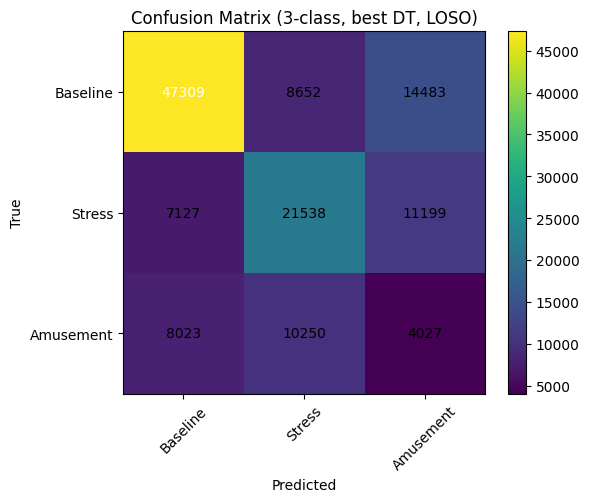

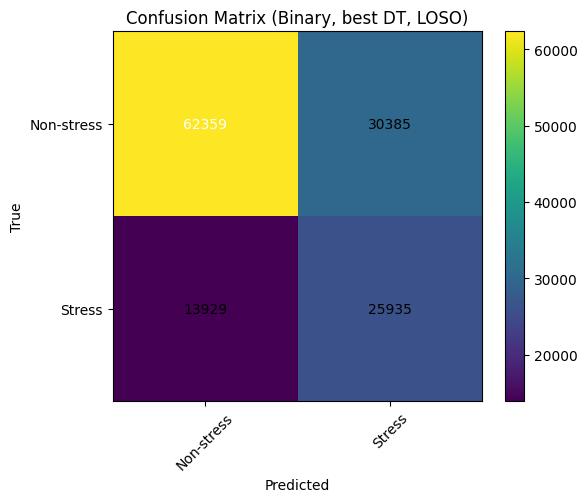

In [22]:
#Confusion matrix
plot_cm(cm_3, ["Baseline","Stress","Amusement"], "Confusion Matrix (3-class, best DT, LOSO)")
plot_cm(cm_b, ["Non-stress","Stress"],          "Confusion Matrix (Binary, best DT, LOSO)")


Top features (3-class):
 C_EDA      3.913925e-01
C_TEMP     3.141615e-01
W_ACC_X    2.284646e-01
W_ACC_Y    4.252275e-02
W_ACC_Z    1.309188e-02
W_TEMP     5.409848e-03
W_EDA      3.469896e-03
C_EMG      1.425303e-03
C_RESP     5.108279e-05
W_BVP      1.061622e-05
C_ECG      2.428162e-15
dtype: float64

Top features (Binary):
 C_EDA      0.405862
C_TEMP     0.333334
W_ACC_Z    0.182153
W_ACC_X    0.056227
W_ACC_Y    0.014718
W_EDA      0.006438
W_TEMP     0.001158
C_ECG      0.000048
C_EMG      0.000043
C_RESP     0.000015
W_BVP      0.000004
dtype: float64


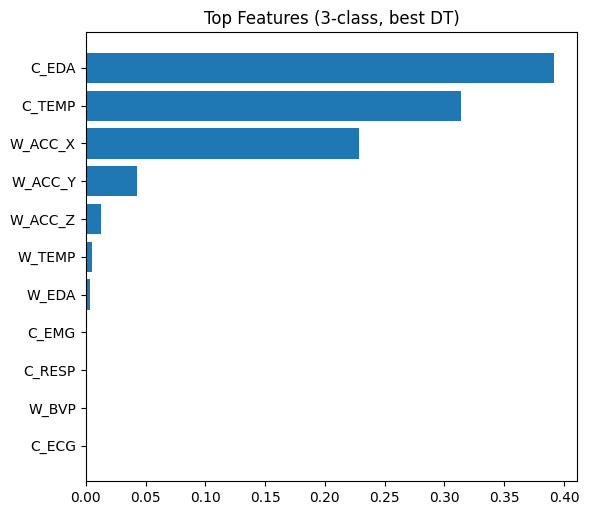

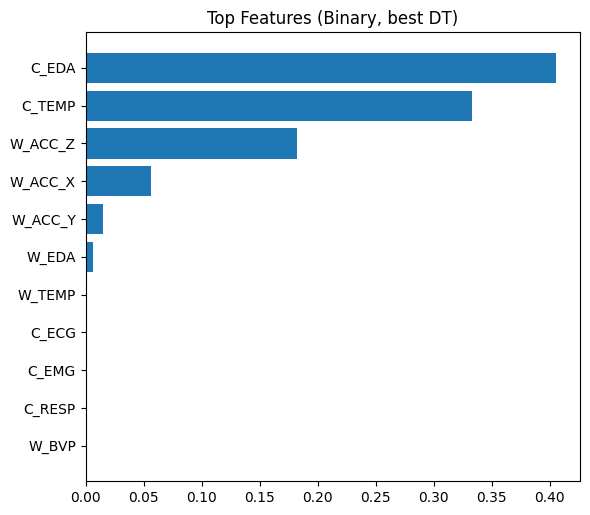

In [23]:
#Feature importance
def fold_feature_importances(X, y, groups, model, feature_names):
    logo = LeaveOneGroupOut()
    rows = []
    for tr, te in logo.split(X, y, groups):
        model.fit(X[tr], y[tr])
        rows.append(pd.Series(model.feature_importances_, index=feature_names))
    imp_df = pd.DataFrame(rows)
    return imp_df, imp_df.mean().sort_values(ascending=False)

imp_df_3, imp_mean_3 = fold_feature_importances(X3, y3, g3, best_tree_multi, FEATURES)
imp_df_b, imp_mean_b = fold_feature_importances(Xb, yb, gb, best_tree_bin,   FEATURES)

print("\nTop features (3-class):\n", imp_mean_3.head(15))
print("\nTop features (Binary):\n", imp_mean_b.head(15))

def plot_top_importances(imp, k=15, title="Feature importance"):
    top = imp.head(k)[::-1]
    plt.figure(figsize=(6, max(3, 0.35*k)))
    plt.barh(top.index, top.values)
    plt.title(title); plt.tight_layout(); plt.show()

plot_top_importances(imp_mean_3, title="Top Features (3-class, best DT)")
plot_top_importances(imp_mean_b, title="Top Features (Binary, best DT)")

In [33]:
#Wrist and chest only features

WRIST_COLS = [c for c in FEATURES if c.startswith("W_")]
CHEST_COLS = [c for c in FEATURES if c.startswith("C_")]

def _select_X(df, cols, mask):
    if mask.dtype != bool:
        raise ValueError("mask must be boolean for .loc; use .iloc for integer positions.")
    return df.loc[mask, cols].to_numpy(float)

In [34]:
# multiclass (1,2,3)
m3 = df["Label"].isin([1,2,3]).values
y3 = df.loc[m3, "Label"].to_numpy(int)
g3 = df.loc[m3, "subject_id"].to_numpy(str)

# binary: stress (2) vs non-stress (1,3)
mb = df["Label"].isin([1,2,3])
yb = (df.loc[mb, "Label"] == 2).astype(int)
gb = df.loc[mb, "subject_id"].to_numpy(str)

# wrist-only
X3_wrist = df.loc[m3, WRIST_COLS].to_numpy(float)
Xb_wrist = _select_X(df, WRIST_COLS, mb)

# chest-only
X3_chest = _select_X(df, CHEST_COLS, m3)
Xb_chest = _select_X(df, CHEST_COLS, mb)

In [38]:
# All column lists should be strings
assert all(isinstance(c, str) for c in WRIST_COLS), "WRIST_COLS contains non-string entries"
assert all(isinstance(c, str) for c in CHEST_COLS), "CHEST_COLS contains non-string entries"

# Masks must be boolean
m3 = df["Label"].isin([1,2,3]).values
mb = df["Label"].isin([1,2,3]).values
assert m3.dtype == bool and mb.dtype == bool

# Build X as NUMPY (no pandas inside LOSO later)
X3_wrist = df.loc[m3, WRIST_COLS].to_numpy(float)
X3_chest = df.loc[m3, CHEST_COLS].to_numpy(float)
Xb_wrist = df.loc[mb, WRIST_COLS].to_numpy(float)
Xb_chest = df.loc[mb, CHEST_COLS].to_numpy(float)

y3 = df.loc[m3, "Label"].to_numpy(int)
g3 = df.loc[m3, "subject_id"].to_numpy(str)
yb = (df.loc[mb, "Label"] == 2).astype(int).to_numpy()
gb = df.loc[mb, "subject_id"].to_numpy(str)

In [39]:
N_TRIALS = 40 

def fit_best_dt(X, y, g, average, class_weight=None, study_name="dt"):
    study = optuna.create_study(direction="maximize", study_name=study_name)
    study.optimize(make_objective(X, y, g, average, class_weight), n_trials=N_TRIALS)
    best = DecisionTreeClassifier(random_state=42, **study.best_params)

    # final LOSO eval with best params
    rows, y_true_all, y_pred_all = [], [], []
    for tr, te in LeaveOneGroupOut().split(X, y, g):
        mdl = DecisionTreeClassifier(random_state=42, **study.best_params)
        mdl.fit(X[tr], y[tr])
        yp = mdl.predict(X[te])
        y_true_all.extend(y[te]); y_pred_all.extend(yp)
        acc = accuracy_score(y[te], yp)
        pr, rc, f1, _ = precision_recall_fscore_support(y[te], yp, average=average, zero_division=0)
        rows.append({"subject": g[te][0], "accuracy": acc, "precision": pr, "recall": rc, "f1": f1})
    per_subject = pd.DataFrame(rows).sort_values("subject")
    summary = per_subject[["accuracy","precision","recall","f1"]].mean().to_dict()
    cm = confusion_matrix(y_true_all, y_pred_all)
    return best, study.best_params, per_subject, summary, cm

# run DT (multiclass)
dt_wrist_m, p_dt_w_m, ps_dt_w_m, sm_dt_w_m, cm_dt_w_m = fit_best_dt(
    X3_wrist, y3, g3, average="macro", class_weight="balanced", study_name="dt_wrist_multiclass"
)
dt_chest_m, p_dt_c_m, ps_dt_c_m, sm_dt_c_m, cm_dt_c_m = fit_best_dt(
    X3_chest, y3, g3, average="macro", class_weight="balanced", study_name="dt_chest_multiclass"
)

# run DT (binary)
dt_wrist_b, p_dt_w_b, ps_dt_w_b, sm_dt_w_b, cm_dt_w_b = fit_best_dt(
    Xb_wrist, yb, gb, average="binary", class_weight="balanced", study_name="dt_wrist_binary"
)
dt_chest_b, p_dt_c_b, ps_dt_c_b, sm_dt_c_b, cm_dt_c_b = fit_best_dt(
    Xb_chest, yb, gb, average="binary", class_weight="balanced", study_name="dt_chest_binary"
)

[I 2025-09-15 06:30:35,134] A new study created in memory with name: dt_wrist_multiclass
[I 2025-09-15 06:30:39,296] Trial 0 finished with value: 0.5050110068237464 and parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 26, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5050110068237464.
[I 2025-09-15 06:30:43,239] Trial 1 finished with value: 0.49895067779133484 and parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 11, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5050110068237464.
[I 2025-09-15 06:30:48,615] Trial 2 finished with value: 0.497082195540875 and parameters: {'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 62, 'min_samples_leaf': 2, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5050110068237464.
[I 2025-09-15 06:30:51,323] Trial 3 finished with value: 0.504744338083348 and parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_

In [41]:
#Aggregate performance for Decision Tree 
def summarize_results(name, preds, y_true, average="macro"):
    acc = accuracy_score(y_true, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, preds, average=average
    )
    print(f"\n=== {name} ===")
    print({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    })

# Multiclass (1/2/3)
print("\nDT Wrist (Multiclass) — subject-macro:", {k: round(v,4) for k,v in sm_dt_w_m.items()})
print("DT Wrist (Multiclass) — pooled/micro: ", {k: round(v,4) for k,v in pooled_metrics_from_cm(cm_dt_w_m, "multiclass").items()})

print("\nDT Chest (Multiclass) — subject-macro:", {k: round(v,4) for k,v in sm_dt_c_m.items()})
print("DT Chest (Multiclass) — pooled/micro: ", {k: round(v,4) for k,v in pooled_metrics_from_cm(cm_dt_c_m, "multiclass").items()})

# Binary (stress vs non-stress)
print("\nDT Wrist (Binary) — subject-macro:", {k: round(v,4) for k,v in sm_dt_w_b.items()})
print("DT Wrist (Binary) — pooled/micro: ", {k: round(v,4) for k,v in pooled_metrics_from_cm(cm_dt_w_b, "binary").items()})

print("\nDT Chest (Binary) — subject-macro:", {k: round(v,4) for k,v in sm_dt_c_b.items()})
print("DT Chest (Binary) — pooled/micro: ", {k: round(v,4) for k,v in pooled_metrics_from_cm(cm_dt_c_b, "binary").items()})


DT Wrist (Multiclass) — subject-macro: {'accuracy': 0.5975, 'precision': 0.529, 'recall': 0.5513, 'f1': 0.5246}
DT Wrist (Multiclass) — pooled/micro:  {'accuracy': np.float64(0.5973), 'precision': np.float64(0.5973), 'recall': np.float64(0.5973), 'f1': np.float64(0.5973)}

DT Chest (Multiclass) — subject-macro: {'accuracy': 0.4786, 'precision': 0.3847, 'recall': 0.4319, 'f1': 0.3759}
DT Chest (Multiclass) — pooled/micro:  {'accuracy': np.float64(0.4787), 'precision': np.float64(0.4787), 'recall': np.float64(0.4787), 'f1': np.float64(0.4787)}

DT Wrist (Binary) — subject-macro: {'accuracy': 0.7109, 'precision': 0.4911, 'recall': 0.6719, 'f1': 0.5636}
DT Wrist (Binary) — pooled/micro:  {'accuracy': np.float64(0.7123), 'precision': np.float64(0.5164), 'recall': np.float64(0.6761), 'f1': np.float64(0.5856)}

DT Chest (Binary) — subject-macro: {'accuracy': 0.6369, 'precision': 0.438, 'recall': 0.6874, 'f1': 0.4837}
DT Chest (Binary) — pooled/micro:  {'accuracy': np.float64(0.6365), 'precis